In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StringType, DoubleType

spark = SparkSession.builder \
    .appName("FraudDetectionStreamingApp") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0") \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")


In [2]:
from pyspark.sql import SparkSession

# Step 1: Create a Spark session
spark = SparkSession.builder \
    .appName("FraudDetection") \
    .getOrCreate()

# Step 2: Load the dataset (update the path as needed)
df = spark.read.csv("/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv", header=True, inferSchema=True)

# Step 3: Show top 5 rows
df.show(5)


+---+--------------------+--------------------+------------------+--------------------+-------------------+------------------+------------------+--------------------+-------------------+------------------+--------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------+-----+
| id|                  V1|                  V2|                V3|                  V4|                 V5|                V6|                V7|                  V8|                 V9|               V10|                 V11|               V12|                V13|                V14|                V15|                 V16|                V17|                V18|                V19|                V20|      

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# Assuming features include V1 to V28 + Amount
feature_cols = [col for col in df.columns if col not in ['Class', 'Time']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
df_vector = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features_vec", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)


In [4]:
pandas_df = df_scaled.select("features", "Class").toPandas()
import numpy as np

X = np.vstack(pandas_df["features"].values)
y = pandas_df["Class"].values


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

model = Sequential([
    Dense(32, input_dim=X.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9900 - loss: 0.0366 - recall: 0.9811 - val_accuracy: 1.0000 - val_loss: 2.3587e-13 - val_recall: 1.0000
Epoch 2/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9992 - loss: 0.0031 - recall: 0.9987 - val_accuracy: 1.0000 - val_loss: 2.7910e-23 - val_recall: 1.0000
Epoch 3/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9995 - loss: 0.0021 - recall: 0.9992 - val_accuracy: 1.0000 - val_loss: 1.7298e-33 - val_recall: 1.0000
Epoch 4/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9995 - loss: 0.0019 - recall: 0.9992 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 5/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9995 - loss: 0.0020 - recall: 0.9992 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 6/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9996 - loss: 0.0016 - recall: 0.9992 - val_accuracy: 1.0000 - val_

In [7]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(weights))

model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2, class_weight=class_weights)


Epoch 1/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9997 - loss: 0.0012 - recall: 0.9994 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 2/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9997 - loss: 0.0012 - recall: 0.9994 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 3/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9997 - loss: 0.0012 - recall: 0.9994 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 4/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9997 - loss: 0.0013 - recall: 0.9994 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 5/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9997 - loss: 0.0011 - recall: 0.9995 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 6/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9998 - loss: 0.0011 - recall: 0.9996 - val_accuracy: 1.0000 - val_

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train SVM
svm_model = SVC(kernel='rbf', class_weight='balanced')  # class_weight handles imbalance
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


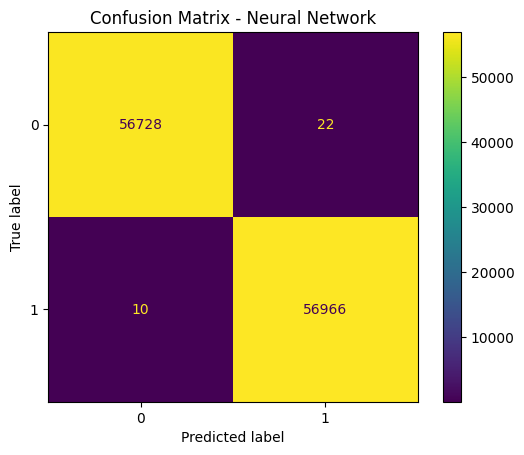

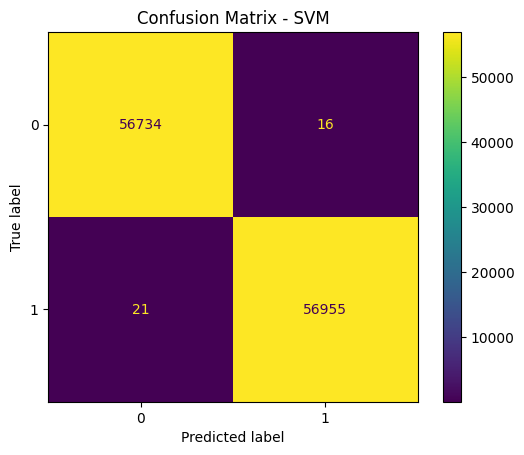

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Neural Network predictions
y_nn_pred = model.predict(X_test)
y_nn_pred_classes = (y_nn_pred > 0.5).astype(int).flatten()

# Confusion Matrix for Neural Network
cm_nn = confusion_matrix(y_test, y_nn_pred_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot()
plt.title("Confusion Matrix - Neural Network")
plt.show()

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title("Confusion Matrix - SVM")
plt.show()


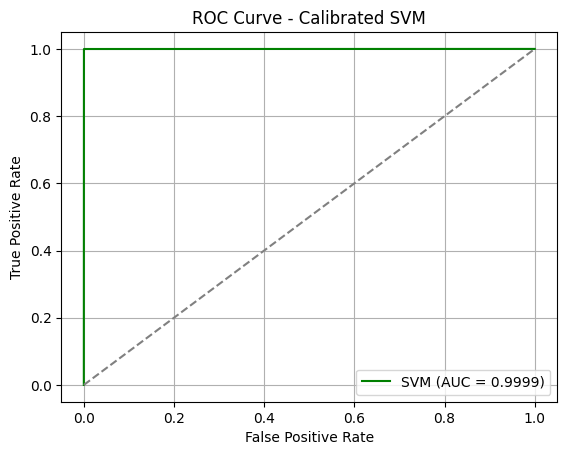

In [10]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc

# Calibrate SVM with a portion of test data
svm_calibrated = CalibratedClassifierCV(svm_model, cv='prefit')

# Fit the calibration model using part of the test data
# This is necessary to estimate probabilities for ROC
svm_calibrated.fit(X_test, y_test)

# Predict probabilities
y_svm_proba = svm_calibrated.predict_proba(X_test)[:, 1]

# ROC Curve and AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_svm_proba)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.4f)' % roc_auc_svm, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Calibrated SVM")
plt.legend()
plt.grid()
plt.show()


Epoch 1/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9998 - loss: 0.0011 - recall: 0.9995 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 2/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9998 - loss: 8.3762e-04 - recall: 0.9996 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 3/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9998 - loss: 8.5759e-04 - recall: 0.9996 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 4/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9998 - loss: 6.4950e-04 - recall: 0.9997 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 5/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9998 - loss: 8.7536e-04 - recall: 0.9996 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 6/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9998 - loss: 9.4288e-04 - recall: 0.9996 - val_acc

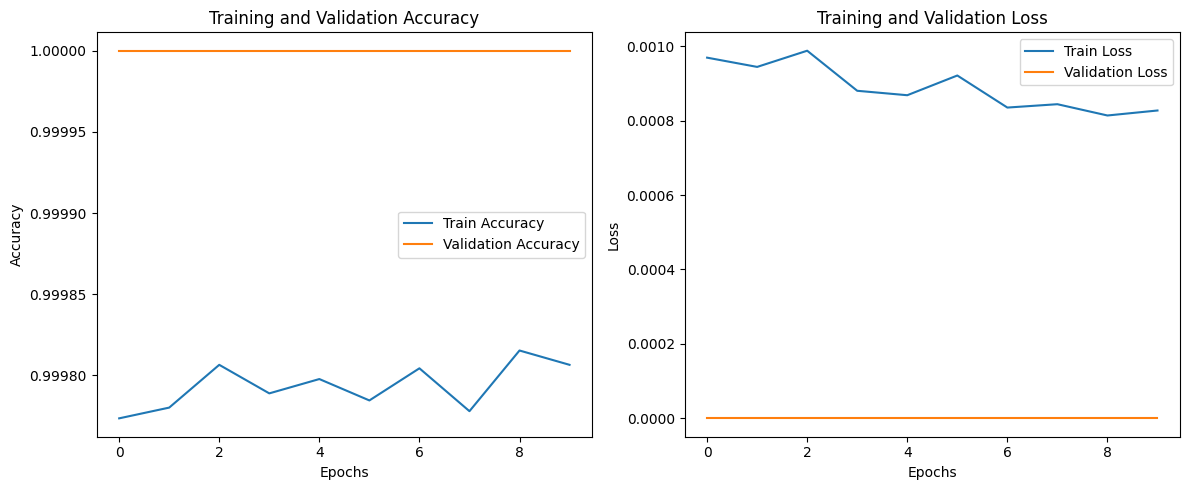

In [11]:
# Make sure you're using the correct history object returned by model.fit()
history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2, class_weight=class_weights)

# Now plot using history.history
import matplotlib.pyplot as plt

# Accuracy and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
